One of the ideas I spoke about with Christoph is comparing the training details of RTRL's trained in temporal contexts vs those trained with randomly uncorrelated data. Training in context enables fine tuning of contextual information, while training on orthogonal data makes the network more versatile. 

Some tasks: 
1. The objective here is to see if I can successfully train the RTRL to play the standard game of life. Because it is also a temporal 

In [103]:
from pylab import *
from scipy.cluster import vq
from Cluster import genCorrelationMatrix
import scipy.cluster.hierarchy as sch  


%matplotlib inline
def index_min(values):
    return min(xrange(len(values)),key=values.__getitem__)

# Distance by the euclidean metric
def ME(A,B): return np.sqrt(np.sum((B-A)**2))

solutions = load('./1000_weights.npy').reshape((1000, 9*6))[:,1:]

In [104]:
# The number of clusters
K = 6
def whiten(obs):
     std_dev = std(obs)
     return obs / std_dev
kmeanable = whiten(solutions)
centroids, labels = vq.kmeans2(kmeanable, k=K)

zipped = array([range(len(labels)), labels]).T
assigned_sorted = zipped[zipped[:, 1].argsort()]
assigned = array([assigned_sorted[assigned_sorted[:,1] ==i][:,0] for i in arange(K)])
representatives = []

for i in xrange(len(centroids)):
    distances = map(lambda a: ME(solutions[a], centroids[i]), assigned[i])
    if (len(distances)!=0): 
        representatives.append(solutions[assigned[i][argmax(distances)]])

So we have the 6 neurons most highly representative of their respective clusters. 
Now we need to compare the permutation similarityt to see if the fact that 6 clusters exist is an artifact of the permutability of the hidden neurons. 

In [105]:
from itertools import permutations
from mpl_toolkits.axes_grid1 import make_axes_locatable


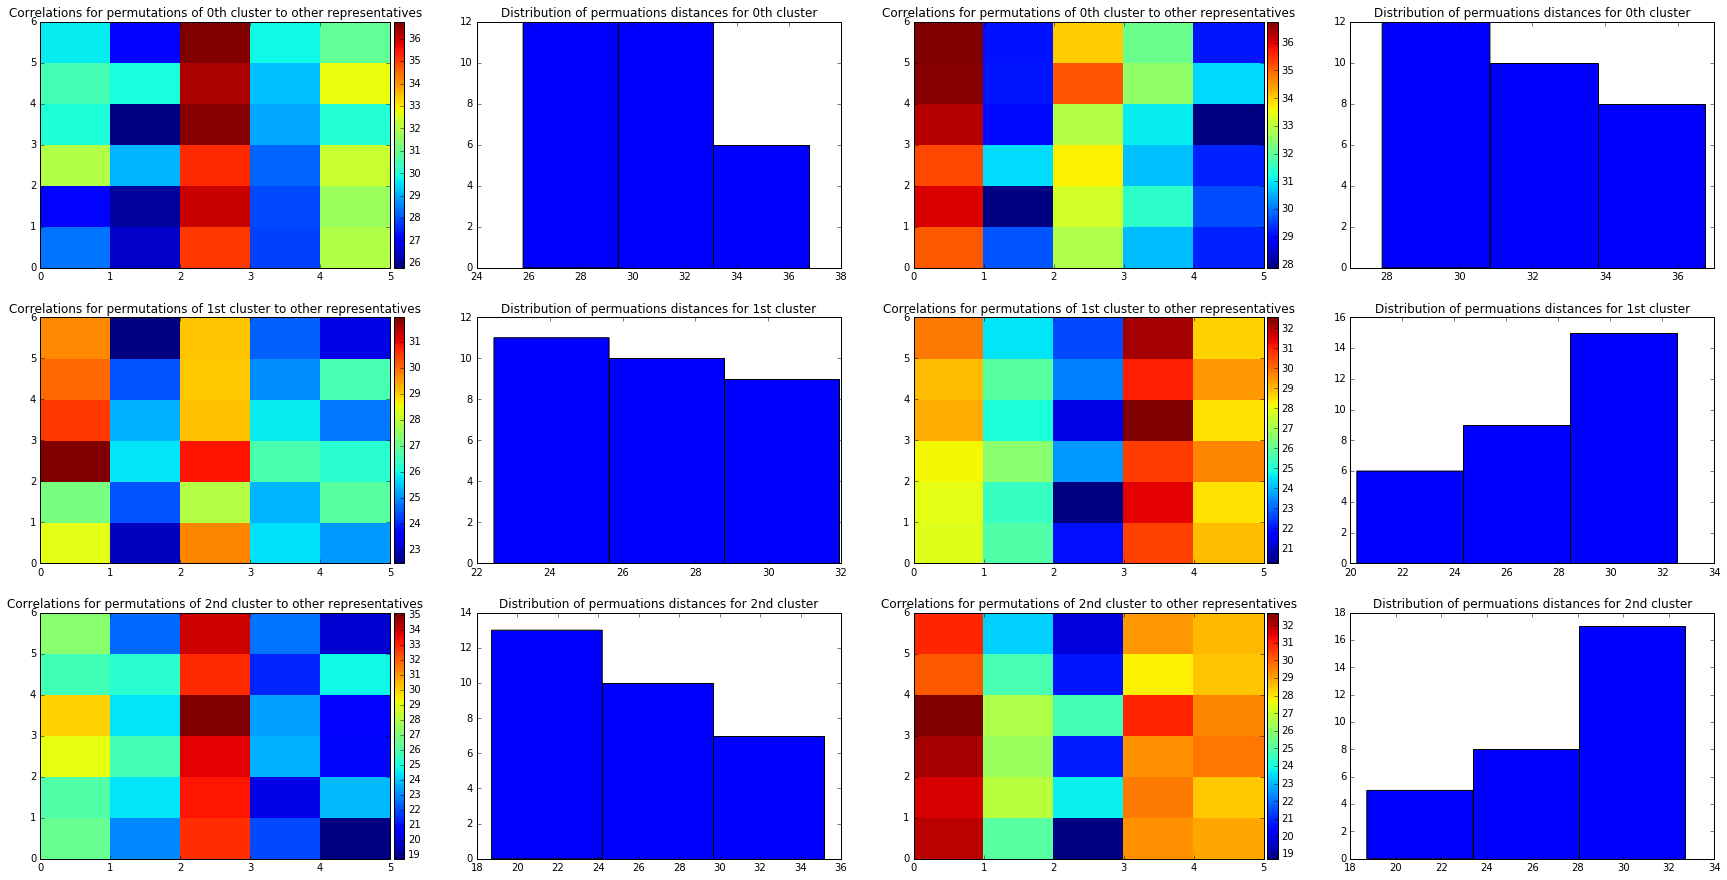

In [211]:
# The number of hidden neurons
p = list(permutations(range(3,6),3))
permutes = [ [0,1,2] + list(j) for j in p ]
distances = []

c = 6

f, ax = subplots(3,4,figsize=(30,15))

iths=['th','st','nd','rd','th','th']

for i in xrange(0,c):
    
    # Distances from representatives[i]
    # permutation[js] to other representatives
    pdists = []
    for j in xrange(len(p)):
        # Distances from ith permutation of representative[j]
        # to other representatives
        permdists = []
        for h in xrange(0,c):
            if (h==i): continue
            temp = zeros(54)
            temp[1:] = representatives[i]
            a = temp.reshape((6,9))[permutes[j]].reshape(54)[1:]
            b = representatives[h]
            permdists.append(ME(a,b))
        pdists.append(permdists)
    distances.append(pdists)
    
    
    correlations = genCorrelationMatrix(solutions[assigned[i]])
    Z = sch.linkage(correlations, method='centroid')
    indexs = sch.leaves_list(Z)
    
    clustered_correl = correlations[indexs][:,indexs]
    
    ind = (i)%3
    b = 1 if i <3 else 3
    a = 0 if i <3 else 2
    ax[ind,a].set_title("Correlations for permutations of {0}{1} cluster to other representatives".format(ind,iths[ind]))
    pc = ax[ind, a].pcolormesh(pdists) 
    div = make_axes_locatable(ax[ind,a])
    # Append axes to the right of ax3, with 20% width of ax3
    cax = div.append_axes("right", size="3%", pad=0.05)
    # Create colorbar in the appended axes
    # Tick locations can be set with the kwarg `ticks`
    # and the format of the ticklabels with kwarg `format`
    cbar = plt.colorbar(pc, cax=cax, ticks=MultipleLocator(1), format="%.0f")

    
    ax[ind,b].set_title("Distribution of permuations distances for {0}{1} cluster".format(ind,iths[ind]))
    ax[ind,b].hist(array(pdists).flatten(),bins=3)

# tight_layout()

plt.savefig('./permutations_distributions.jpg',dpi=400)

In [217]:
from Cluster import genCorrelationMatrix

print permutes
print array(distances)

[[0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 5, 4], [0, 1, 2, 4, 3, 5], [0, 1, 2, 4, 5, 3], [0, 1, 2, 5, 3, 4], [0, 1, 2, 5, 4, 3]]
[[[ 28.41220355  26.49900819  35.09869609  27.85213812  31.97881927]
  [ 27.17160769  26.05122695  36.04514316  27.953776    31.67883625]
  [ 31.95361571  29.07772559  35.26454648  28.22240575  32.2669619 ]
  [ 30.04509683  25.77130917  36.65760921  28.9723587   30.10013176]
  [ 30.51275694  29.94848715  36.30324142  29.20884646  32.72253854]
  [ 29.69275448  27.18619398  36.75300714  29.83920407  30.89857352]]

 [[ 28.41220355  22.997461    29.7435805   25.76242127  25.06581484]
  [ 27.17160769  24.43325356  27.87227625  25.35294014  26.77610086]
  [ 31.95361571  25.79907486  30.909923    26.63236812  26.25311722]
  [ 30.51275694  25.31022327  29.1638791   25.84832955  24.79596495]
  [ 30.04509683  24.44912847  29.0749631   24.96694857  26.5886408 ]
  [ 29.69275448  22.46495836  29.12522585  24.55875416  23.32177158]]

 [[ 26.49900819  22.997461    32.86388535  21.9

In [199]:
correlations = array(distances)

Z = sch.linkage(correlations, method='centroid')
indexs = sch.leaves_list(Z)

clustered_correl = correlations[indexs][:,indexs]
pcolormesh(clustered_correl)
colorbar()

figure()
hist(distances[0])

UnboundLocalError: local variable 'Z' referenced before assignment